# Анализ данных для рекламной компании магазина компьютерных игр

**ОПИСАНИЕ ПРОЕКТА**

Интернет-магазин продаёт компьютерные игры по всему миру. Нам доступны данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед нами данные до 2016 года.

*NB* Данные за 2016 год могут быть неполными.


**ОПИСАНИЕ ДАННЫХ**

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию:

    1. **E** («Everyone») — «Для всех»
    2. **M** («Mature») — «Для взрослых 17+»
    3. **T** («Teen») — «Подросткам»
    4. **E10+** («Everyone 10 and older») — «Для всех от 10 лет и старше»
    5. **K-A** ("Kids to Adults") — вариация категории «Для всех»
    6. **AO** («Adults Only 18+») — «Только для взрослых»
    7. **EC** («Early childhood») — «Для детей младшего возраста»
    8. **RP** («Rating Pending») — «Рейтинг ожидается»

**ОГЛАВЛЕНИЕ ПРОЕКТА**
- Откроем файл с данными и изучим общую информацию
- Подготовим данные
- Проведем исследовательский анализ данных
- Составим портрет пользователя каждого региона
- Проверим гипотезы
- Общий вывод





## Откроем файл с данными и изучим общую информацию

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

In [2]:
# откроем файл и ознакомимся с данными
games = pd.read_csv('/datasets/games.csv' )
games.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
games['Rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Итак, мы импортировали необходимые для работы библиотеки, ознакомились с данными и выявили некоторые неточности, а именно:

- в столбцах Name, Year_of_Release, Critic_Score, User_Score и Rating имеются пропуски (всего строк 16715);
- разный регистр в наименовании столбцов;
- неверный формат данных в столбце Year_of_Release (float64);
- неверный формат данных в столбце User_Score (object);
- категории рейтинга E и K-A являются по сути одной категорией Е.

## Подготовим данные

In [5]:
# приведем названия столбцов к нижнему регистру
games.columns = map(str.lower, games.columns)

In [6]:
# заменим рейтинг К-А на Е
games['rating'] = games['rating'].replace('K-A','E')

В столбцах year_of_release и user_score заменим тип данных, заменив пропущенные значение на -1. Год выпуска - это целое число, поэтому эти значения будут указаны в формате int64, а оценка пользователей - невещественное число, приведем эти значения к формату float64.


In [7]:
games['year_of_release'] = games['year_of_release'].fillna(-1).astype(int)

In [8]:
games['user_score'] = games['user_score'].fillna(-1)

В столбце user_score имеются значения tbd (англ. to be determined - будет определено позднее ) то есть оценка пользователей еще не определена. Заменим эти значения на -1, чтобы изменить тип данных столбца, и будем учитывать эти значения при дальнейших рассчетах.

In [9]:
games['user_score'] = games['user_score'].replace('tbd', -1)
games['user_score'] = pd.to_numeric (games['user_score']) 

Обработаем пропуски в столбцах


In [10]:
games.query('name.isnull()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,-1.0,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,-1.0,NaN


Имеются два пропуска в столбце name. Оба наблюдения от 1993 года со множественными пропусками. Думаю, мы можем их удалить. Вряд ли они повлияют на результат дальнейшего исследования.

In [11]:
games.dropna(subset = ['name'], inplace = True)

В столбце year_of_release не будем обрабатывать неизвестные нам значения или избавляться от строк с пропусками в этом столбце. Оставим их заполненными нехарактерным значением -1 и будем учитывать это в ходе работы.

Пропуски в столбцах critic_score и user_score (также как и в year_of_release и rating) могли появиться по разным причинам. 

В user_score мы уже заполнили пропуски нетипичным значением -1. Сделаем то же самое с пропусками в critic_score и rating, а затем будем учитывать это в дальнейшей работе. Это поможет нам сохранить данные и не повлиять на результаты исследования.

In [12]:
games['critic_score'] = games['critic_score'].fillna(-1)

In [13]:
games['rating'] = games['rating'].fillna(-1)

Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец

In [14]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

In [15]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     16713 non-null  float64
 9   user_score       16713 non-null  float64
 10  rating           16713 non-null  object 
 11  total_sales      16713 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.7+ MB


Итак, на данном этапе мы выполнили следующие шаги:

1. привели названия столбцов к нижнему регистру;
2. преобразовали данные в в нужные типы: year_of_release в формат int64, а в user_score в float64;
3. обработали пропуски - в столбцах сritic_score, user_score и rating где пропущена почти половина значений. Удаление их критично, а заполнение этих пропусков иными данными привело бы к искажению результатов исследования, поэтому заменили их на -1 и будем учитывать это в дальнейшем исследовании;
4. от пропусков в name избавились;
5. в user_score изменили значения tbd на -1;
6. посчитали суммарные продажи во всех регионах и записали их в отдельный столбец total_sales

## Проведем исследовательский анализ данных

Посмотрим, сколько игр выпускалось в разные годы.

Не думаю, что для проведения исследования нам необходимо знать статистику за последние 30 лет. Нам необходимы актуальные данные. Поэтому обратим внимание на изменение продаж у платформ, начиная с 2000 года и определим промежуток времени, который будем исследовать в дальнейшем

Text(0.5, 0, 'Год выпуска')

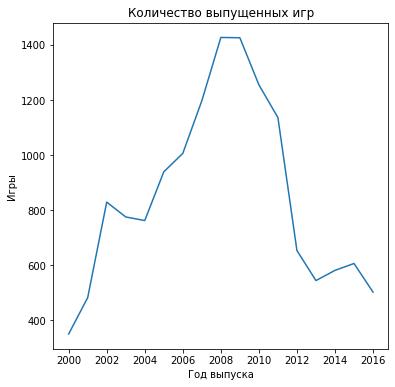

In [16]:
count_by_year = games.query('year_of_release >= 2000').groupby('year_of_release')['name'].count()
count_by_year.plot(figsize=(6,6), title = 'Количество выпущенных игр')
ax = plt.gca()
ax.set_ylabel('Игры')
ax.set_xlabel('Год выпуска')

Видим, что основная масса новых игр приходится на 2006-2012 годы, после этого периода количество выпускающихся игр идет на спад.

Посмотрим, как менялись продажи по платформам и ответим на вопрос:

За какой характерный срок появляются новые и исчезают старые платформы?

In [17]:
games.query('year_of_release > 2000').pivot_table(index='platform',columns='year_of_release',values='name', aggfunc='count', fill_value='-')

year_of_release,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,
3DS,-,-,-,-,-,-,-,-,-,-,116.0,93.0,91.0,80.0,86.0,46.0
DC,8.0,1.0,-,-,-,-,1.0,1.0,-,-,-,-,-,-,-,-
DS,-,-,-,23.0,118.0,201.0,376.0,492.0,403.0,323.0,153.0,23.0,8.0,-,-,-
GB,10.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
GBA,107.0,198.0,150.0,175.0,135.0,39.0,6.0,-,-,-,-,-,-,-,-,-
GC,22.0,152.0,144.0,83.0,97.0,40.0,4.0,-,-,-,-,-,-,-,-,-
N64,9.0,1.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-
PC,15.0,19.0,33.0,30.0,37.0,52.0,62.0,76.0,107.0,90.0,139.0,61.0,38.0,47.0,50.0,54.0
PS,91.0,20.0,3.0,-,-,-,-,-,-,-,-,-,-,-,-,-


По распределению можно заметить смену платформ. Примерно в 2006 на замену старым приходят новые.

Думаю, для дальнейшего исследования нам будет вполне достаточно последних 10 лет. Оставим данные с 2006 года по 2016 включительно.

Выберем несколько потенциально прибыльных платформ

Text(0, 0.5, 'Количество продаж')

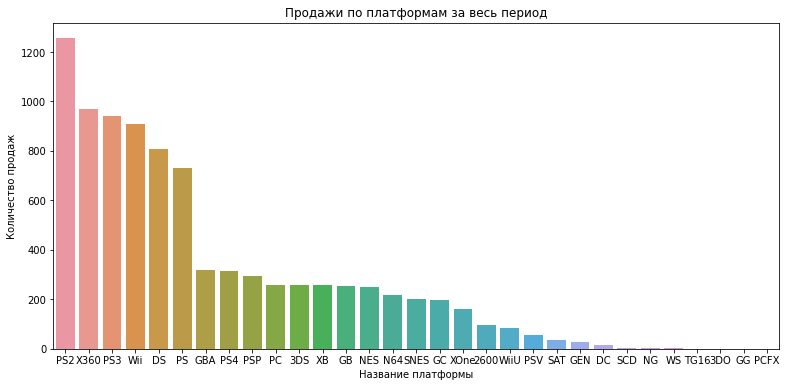

In [18]:
platform_vs_sales = games.pivot_table(
    index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)

plt.figure(figsize=(13,6))
sns.barplot(x=platform_vs_sales.index,y=platform_vs_sales['total_sales'])
plt.title("Продажи по платформам за весь период")
plt.xlabel("Название платформы")
plt.ylabel("Количество продаж")

Из графика видно, что самые популярные игровые платформы за весь период это PS2, X360, PS3, WII, DS, PS

In [19]:
# Напишем функцию, которая будет возвращать нужную сводную таблицу и выводить данные с 2005 года
def year_total_sale_for_platform(name, data):
    slicee = data[(data['platform'] == name) & (data['year_of_release'] > 2005)]
    total = slicee.pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').sort_values('year_of_release', ascending=False)
    return total

In [20]:
# взглянем на суммы
platform_sales = games.groupby('platform')['total_sales'].sum().sort_values(ascending=False).reset_index().head(5)

In [21]:
platform_sales

,platform,total_sales
0,PS2,1255.77
1,X360,971.42
2,PS3,939.65
3,Wii,907.51
4,DS,806.12


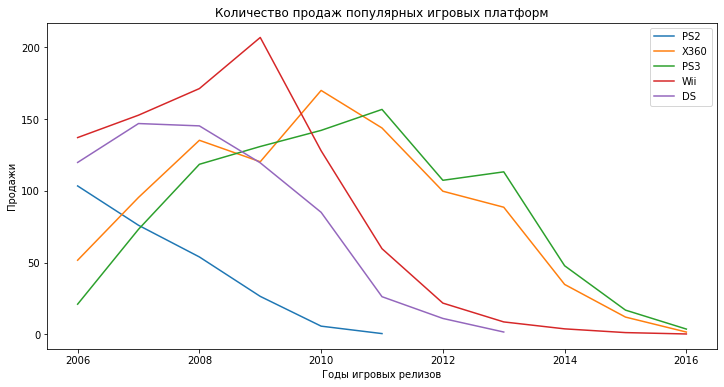

In [22]:
#Отрисуем все игровые платформы и их поведение за последние 10 лет
plt.figure(figsize=(12,6))
plt.title('Количество продаж популярных игровых платформ')
plt.xlabel('Годы игровых релизов')
plt.ylabel('Продажи')

for i in list(platform_sales['platform']):
    sns.lineplot(data=year_total_sale_for_platform(i,games)['total_sales'], label=i)
    plt.legend()

Можем сделать вывод, что 
- Практически все игровые платформы в среднем существуют по 10 лет. 
- Cамые продаваемые это Sony Play Station и XBOX 
- Самый пик наступает примерно через 5 лет после выхода приставки
- у Nintento WII был быстрый скачок в 2009 году и такой же резкий провал


<div class="alert alert-success"; style="border-left: 7px solid green">
<h3>✔ Комментарий ревьюера V.2</h3>
    
Примерно так, да. Если построить по всем платформам, которые дожили до 2016 года, то можно будет увидеть, почему 2012-13 это акутальный перидо, у большинства платформ продажи упали, а у некоторых пошли вверх, поэтому учитывать старые данные для упавших не стоит. Посчитать среднее время жизни можно так:
</div>    


In [25]:
# Код ревьюера

games.groupby('platform')['year_of_release'].nunique().median()

8.0

In [26]:
# для анализа возьмем данные с 2012 года
games_new = games.query('year_of_release >=2012')

In [27]:
# найдем платформы с наибольшими суммарными продажами
platform_sales = games_new.groupby('platform')['total_sales'].sum().sort_values(ascending=False).reset_index().head(10)

In [28]:
platform_sales.head(10)

,platform,total_sales
0,PS4,314.14
1,PS3,288.79
2,X360,236.54
3,3DS,194.61
4,XOne,159.32
5,WiiU,82.19
6,PC,62.65
7,PSV,49.18
8,Wii,35.37
9,DS,12.55


In [29]:
top_platforms = platform_sales['platform'].to_list()
top_platforms

['PS4', 'PS3', 'X360', '3DS', 'XOne', 'WiiU', 'PC', 'PSV', 'Wii', 'DS']

In [30]:
games_new_top = games_new.query('platform in @top_platforms')
games_new_top.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1.0,-1.0,-1,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,-1.0,-1.0,-1,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


In [31]:
# посмотрим на сводную таблицу уже по новым данным
games_new_top.pivot_table (index='platform',columns='year_of_release',values='total_sales', aggfunc='sum', fill_value='-')

year_of_release,2012,2013,2014,2015,2016
platform,,,,,
3DS,51.36,56.57,43.76,27.78,15.14
DS,11.01,1.54,-,-,-
PC,23.22,12.38,13.28,8.52,5.25
PS3,107.36,113.25,47.76,16.82,3.6
PS4,-,25.99,100.0,118.9,69.25
PSV,16.19,10.59,11.9,6.25,4.25
Wii,21.71,8.59,3.75,1.14,0.18
WiiU,17.56,21.65,22.03,16.35,4.6
X360,99.74,88.58,34.74,11.96,1.52


Очевидно, что самой прибыльной платформой является PS4. Пик её выручки приходится на 2015 год, а в 2016 уже наблюдается поадение.

Построим «ящики с усами» по глобальным продажам каждой игры и c разбивкой по платформам

Text(0, 0.5, 'Глобальные продажи')

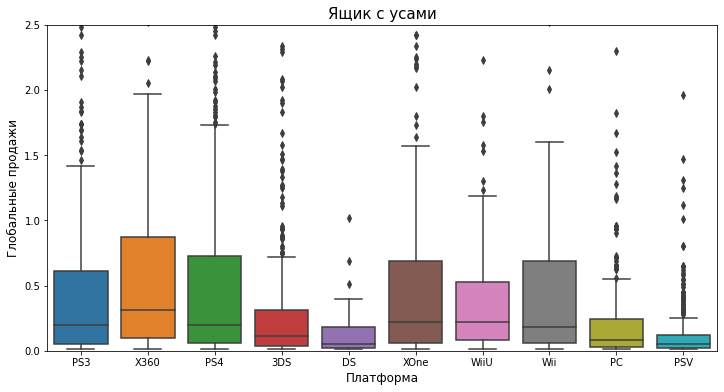

In [32]:
#Отрисуем ящики с усами 
ax = plt.figure(figsize=(12,6))
ax = sns.boxplot(data=games_new_top, x='platform', y='total_sales')
ax.set(ylim=(0,2.5))
plt.title('Ящик с усами', fontsize=15)
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Глобальные продажи',fontsize=12)


Провели срез данных для того, чтобы отрисовать ящики с усами. 
- Исходя из графиков видно, что медиана протекает у всех по разному. Заметим, что у платформ ps4, ps3 и wii большая часть значений больше медианного. Наиболее равномерно распределены значения у платформы WiiU.
- Больше всех продаж у X360, затем следуют PS4, XOne, WII и PS3. 

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Выручка, млн дол.')

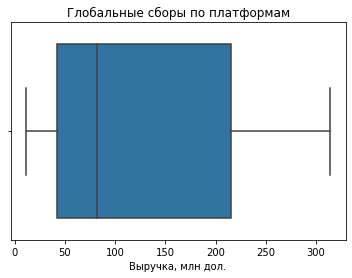

In [33]:
p = games_new.groupby('platform')['total_sales'].sum().reset_index()
ax = sns.boxplot('total_sales', data=p)
ax.set_title('Глобальные сборы по платформам')
ax.set_xlabel('Выручка, млн дол.')

Основная часть значений находится в промежутке 48 - 220

Text(0, 0.5, '')

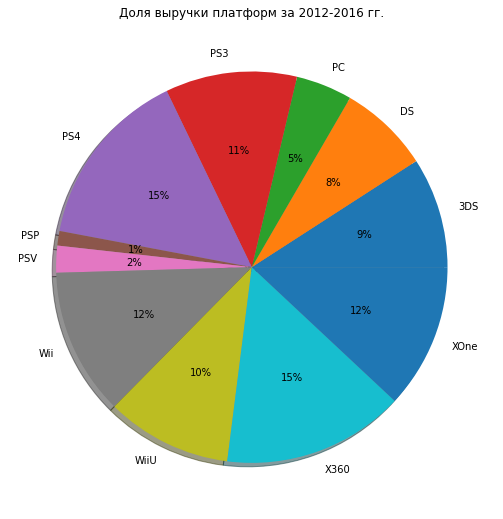

In [34]:
#посмотрим на среднюю выручку платформ по годам за выбранный период
revenue_mean = games_new.groupby('platform')['total_sales'].mean()
revenue_mean.plot(kind='pie', figsize=(9, 9), autopct='%1.0f%%', shadow=True, title='Доля выручки платформ за 2012-2016 гг.')
ax = plt.gca()
ax.set_ylabel('')

За выбранный период есть несколько лидеров по средним продажам - PS4, X360, PS3, Wii и XOne.

Посмотрим, как влияют на продажи внутри одной популярной платформы (PS4) отзывы пользователей и критиков. Построим диаграммы рассеяния и посчитаем корреляцию между отзывами и продажами.

In [35]:
#выделим в отдельную таблицу продажи по PS4
games_ps4 = games_new.query('platform == "PS4" and user_score != -1 and critic_score != -1')

Text(0.5, 0, 'Оценка пользователей')

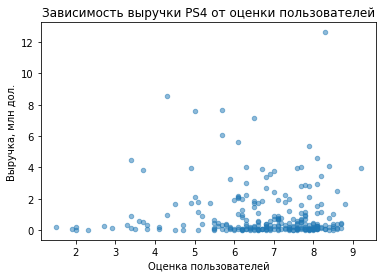

In [36]:
games_ps4.plot(y='total_sales', x='user_score', kind='scatter', alpha=0.5, title='Зависимость выручки PS4 от оценки пользователей')
ax = plt.gca()
ax.set_ylabel('Выручка, млн дол.')
ax.set_xlabel('Оценка пользователей')

In [37]:
games_ps4['total_sales'].corr(games_ps4['user_score'])

-0.03362497596528878

Text(0.5, 0, 'Оценка критиков')

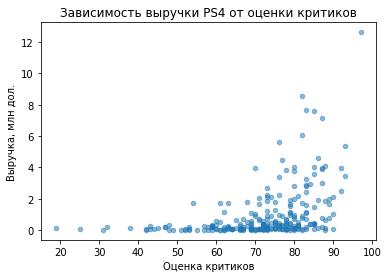

In [38]:
games_ps4.plot(y='total_sales', x='critic_score', kind='scatter', alpha=0.5, title='Зависимость выручки PS4 от оценки критиков')
ax = plt.gca()
ax.set_ylabel('Выручка, млн дол.')
ax.set_xlabel('Оценка критиков')

In [39]:
games_ps4['total_sales'].corr(games_ps4['critic_score'])

0.40589480145836687

И по графикам, и по значению корреляции видим, что отзывы критиков в большей степени влияют на продажи, чем отзывы пользователей. Больше всего выручка при оценке критиков 70 и выше.

Посмотрим как графики и корреляция будут выглядеть для всех десяти платформ.

Text(0.5, 0, 'Оценка пользователей')

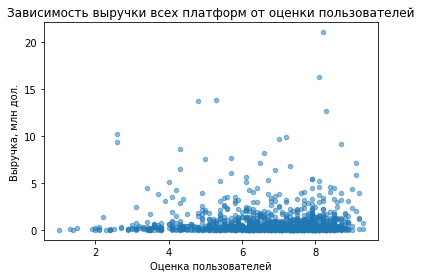

In [40]:
games_new_filtered = games_new.query('user_score != -1 and critic_score != -1')
games_new_filtered.plot(y='total_sales', x='user_score', kind='scatter', alpha=0.5, title='Зависимость выручки всех платформ от оценки пользователей')
ax = plt.gca()
ax.set_ylabel('Выручка, млн дол.')
ax.set_xlabel('Оценка пользователей')

In [41]:
games_new_filtered['total_sales'].corr(games_new_filtered['user_score'])

0.0005966665040503188

Text(0.5, 0, 'Оценка критиков')

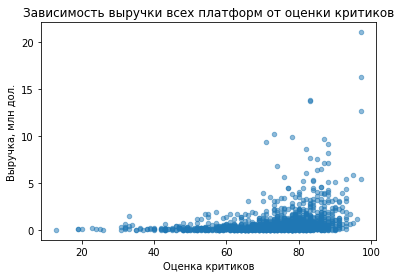

In [42]:
games_new_filtered.plot(y='total_sales', x='critic_score', kind='scatter', alpha=0.5, title='Зависимость выручки всех платформ от оценки критиков')
ax = plt.gca()
ax.set_ylabel('Выручка, млн дол.')
ax.set_xlabel('Оценка критиков')

In [43]:
games_new_filtered['total_sales'].corr(games_new_filtered['critic_score'])

0.30651579412925023

При взгляде на два последних графика можно заметить, что разница в корреляции оценка критика/выручка и оценка пользователя/выручка совсем небольшая. Для платформы PS4 она заметнее, а корреляция оценка критика/выручка сильнее.

Посмотрим на общее распределение игр по жанрам.

In [44]:
# Методом сводных таблиц выведем жанры и их продажи.  отсортируем по убыванию. 
distr_genre = games_new.pivot_table(
    index='genre', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)
distr_genre = distr_genre.reset_index().rename_axis(None, axis=1)
distr_genre

,genre,total_sales
0,Action,441.12
1,Shooter,304.73
2,Role-Playing,192.80
3,Sports,181.07
4,Misc,85.04
5,Platform,61.00
6,Racing,53.50
7,Fighting,44.49
8,Simulation,35.12
9,Adventure,29.43


Text(0, 0.5, 'Продажи')

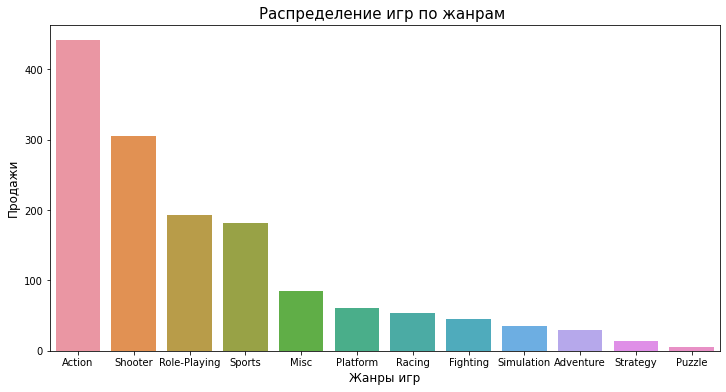

In [45]:
#Отрисуем барплот чтобы наглядно посмотреть какие жанры лидирует, а какие остаются внизу
plt.figure(figsize=(12,6))
plt.title('Распределение игр по жанрам ',fontsize=15)
sns.barplot(data=distr_genre, x='genre', y='total_sales')
plt.xlabel('Жанры игр',fontsize=12)
plt.ylabel('Продажи',fontsize=12)

Лидируют игры жанра Action, за ними идут жанры Sports и Shooter. Самые низкие сборы у жанров Adventure, Puzzle и Strategy.

Text(0, 0.5, 'Глобальные продажи')

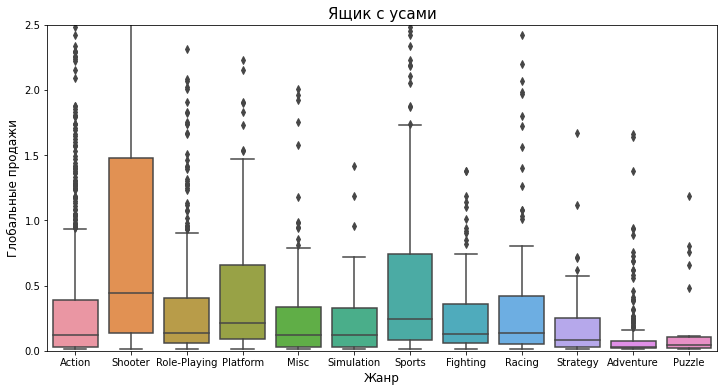

In [46]:
ax = plt.figure(figsize=(12,6))
ax = sns.boxplot(data=games_new, x='genre', y='total_sales')
ax.set(ylim=(0,2.5))
plt.title('Ящик с усами', fontsize=15)
plt.xlabel('Жанр', fontsize=12)
plt.ylabel('Глобальные продажи',fontsize=12)



Построили диаграмму размаха, чтобы визуально сравнить распределения. Наблюдаем большую часть значений больше медианного. Степень разброса и асимметрии данных относительно одинаковы, кроме жанров Shooter, Sports и Platform.

**ВЫВОД**

Мы провели исследовательский анализ данных. Для анализа выделили срез данных за 2012-2016 гг, нашли 10 платформ-лидеров по продажам.

1. На примере PS4 мы рассмотрели корреляцию оценка критика/выручка и оценка пользователя/выручка и пришли к выводу, что отзывы критиков в большей степени влияют на продажи, чем отзывы пользователей.

3. Больше всего выручка у платформы при оценке критиков 70 и выше.

4. Самыми прибыльными оказались жанры Action, Sports и Shooter.

5. Самые низкие сборы у жанров Adventure, Strategy и Puzzle.

## Составим портрет пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP):

- самые популярные платформы (топ-5)
- самые популярные жанры (топ-5)
- влияние рейтинга ESRB на продажи в регионе

*Северная Америка*

In [47]:
(games_new
 .groupby('platform')['na_sales']
 .sum()
 .reset_index()
 .sort_values(by='na_sales', ascending=False)
 .head(5)
)

,platform,na_sales
9,X360,140.05
4,PS4,108.74
3,PS3,103.38
10,XOne,93.12
0,3DS,55.31


In [48]:
(games_new
 .groupby('genre')['na_sales']
 .sum()
 .reset_index()
 .sort_values(by='na_sales', ascending=False)
 .head(5)
)

,genre,na_sales
0,Action,177.84
8,Shooter,144.77
10,Sports,81.53
7,Role-Playing,64.00
3,Misc,38.19


In [49]:
(games_new
 .query('rating != -1')
 .groupby('rating')['na_sales']
 .sum()
 .reset_index()
 .sort_values(by='na_sales', ascending=False)
 .head(5)
)

,rating,na_sales
2,M,231.57
0,E,114.37
1,E10+,75.70
3,T,66.02


Итак, 
- в Северной Америке лидируют платформы X360, PS4 и PS3
- самые популярные жанры - Action, Shooter, Sports, Role-Playing и Misc
- лидирует рейтинг "М", затем идут "Е" и "Е10+"

*Европа*

In [50]:
(games_new
 .groupby('platform')['eu_sales']
 .sum()
 .reset_index()
 .sort_values(by='eu_sales', ascending=False)
 .head(5)
)

,platform,eu_sales
4,PS4,141.09
3,PS3,106.86
9,X360,74.52
10,XOne,51.59
0,3DS,42.64


In [51]:
(games_new
 .groupby('genre')['eu_sales']
 .sum()
 .reset_index()
 .sort_values(by='eu_sales', ascending=False)
 .head(5)
)

,genre,eu_sales
0,Action,159.34
8,Shooter,113.47
10,Sports,69.09
7,Role-Playing,48.53
6,Racing,27.29


In [52]:
(games_new
 .query('rating != -1')
 .groupby('rating')['eu_sales']
 .sum()
 .reset_index()
 .sort_values(by='eu_sales', ascending=False)
 .head(5)
)

,rating,eu_sales
2,M,193.96
0,E,113.03
1,E10+,55.37
3,T,52.96


- в Европе лидируют все те же приставки, но распределение немного другое, здесь в топе PS4, затем PS3 и X360
- самые популярные жанры все те же - Action, Shooter, Sport, Role-Playing и Racing, жанр, которого не было среди популярных в Северной Америке
- также лидируют рейтинги "М" и "Е"

*Япония*

In [53]:
(games_new
.groupby('platform')['jp_sales']
.sum()
.reset_index()
.sort_values(by='jp_sales', ascending=False )
.head(5)
)

,platform,jp_sales
0,3DS,87.79
3,PS3,35.29
6,PSV,21.04
4,PS4,15.96
8,WiiU,13.01


In [54]:
(games_new
.groupby('genre')['jp_sales']
.sum()
.reset_index()
.sort_values(by='jp_sales', ascending=False)
.head(5)
)

,genre,jp_sales
7,Role-Playing,65.44
0,Action,52.80
3,Misc,12.86
9,Simulation,10.41
2,Fighting,9.44


In [55]:
(games_new
.query('rating != -1')
.groupby('rating')['jp_sales']
.sum()
.reset_index()
.sort_values(by='jp_sales', ascending=False)
.head(5)
)

,rating,jp_sales
0,E,28.33
3,T,26.02
2,M,21.20
1,E10+,8.19


- А Японии лидируют совсем другие платформы - 3DS, PSP, PSV
- в том 3 самых популярных жанра - Role-Playing, Misc, Action (совсем неагрессивные)
- самые большие продажи у рейтингов "E" (для всех) и "T" (для подростков). 

Похоже, в Японии с уровнем стресса всё в порядке.

*Другие страны*

In [56]:
(games_new
.groupby('platform')['other_sales']
.sum()
.reset_index()
.sort_values(by='other_sales', ascending=False)
.head(5)
)

,platform,other_sales
4,PS4,48.35
3,PS3,43.26
9,X360,20.40
10,XOne,14.27
0,3DS,8.87


In [57]:
(games_new
.groupby('genre')['other_sales']
.sum()
.reset_index()
.sort_values(by='other_sales', ascending=False)
.head(5)
)

,genre,other_sales
0,Action,51.14
8,Shooter,37.26
10,Sports,22.44
7,Role-Playing,14.83
3,Misc,7.67


In [58]:
(games_new
.query('rating != -1')
.groupby('rating')['other_sales']
.sum()
.reset_index()
.sort_values(by='other_sales', ascending=False)
.head(5)
)

,rating,other_sales
2,M,63.38
0,E,31.44
3,T,17.94
1,E10+,16.23


**ВЫВОД**

В *Северной Америке* и *Европе* картина примерно одинакова:

лидируют платформы X360, Wii и DS, PS3 с небольшой разницей в распределении продаж.
самые популярные жанры - Action, Sports,Shooter, Misc
с большим отрывом по продажам лидирует рейтинг E (для всех), на втором месте M (18+)


В *Японии* немного по-другому:

лидируют совсем другие платформы - 3DS, WiiU, DS, PSP, PS3
самые популярные жанры - Role-Playing, Platform, Sports, Misc, Action. В Японии популярные жанры выглядят более безобидно
самые большие продажи у рейтингов E (для всех) и T (для подростков). Похоже, в Японии выбирают более спокойные игры.


*Другие страны*:

для остальных стран портрет потребителя примерно одинаков с потребителями из СА и Европы. Лидируют те же платформы, жанры и рейтинги. Выходит, Япония - достаточно специфический рынок, к которому нужен особый подход в плане рекламных кампаний.

## Проверим гипотезы

**- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые**

Сформулируем нулевую и альтернативную гипотезы. Нулевую гипотезу будем формулировать так, чтобы использовать знак равенства. Альтернативную гипотезу сформулируем оттакливаясь от нулевой гипотезы.

*$H_0$ - средние пользовательские рейтинги платформ Xbox One и PC равны*

*$H_1$ - средние пользовательские рейтинги платформ Xbox One и PC не равны*

In [59]:
# зададим критический уровень статистической значимости
alpha = .05

In [60]:
xone = games_new_filtered.query('platform == "XOne"')
pc = games_new_filtered.query('platform == "PC"')

In [61]:
results = st.ttest_ind(
    xone['user_score'],
    pc['user_score'],
)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print()    
print('Cредний пользовательский рейтинг платформы Xbox One -', xone['user_score'].mean().round(2))
print('Cредний пользовательский рейтинг платформы PC -', pc['user_score'].mean().round(2))

p-значение: 0.5991315923632393
Не получилось отвергнуть нулевую гипотезу

Cредний пользовательский рейтинг платформы Xbox One - 6.54
Cредний пользовательский рейтинг платформы PC - 6.45


**- Cредние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные**

*$H_0$ - средние пользовательские рейтинги жанров Action и Sports равны*

*$H_1$ - средние пользовательские рейтинги жанров Action и Sports не равны*

In [62]:
action = games_new_filtered.query('genre == "Action"')
sports = games_new_filtered.query('genre == "Sports"')

In [63]:
results = st.ttest_ind(
    action['user_score'],
    sports['user_score'],
)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print()    
print('Cредний пользовательский рейтинг жанра Action -', action['user_score'].mean().round(2))
print('Cредний пользовательский рейтинг жанра Sports -', sports['user_score'].mean().round(2))

p-значение: 9.13633279873618e-16
Отвергаем нулевую гипотезу

Cредний пользовательский рейтинг жанра Action - 6.9
Cредний пользовательский рейтинг жанра Sports - 5.82


Мы проверили обе гипотезы. Отвергли вторую, первую отвергнуть не получилось.

## Общий вывод

В ходе работы мы:

- ознакомились с предоставленными данными, выявили ошибки и пропуски в датасете и обработали их: привели названия столбцов к нижнему регистру, преобразовали данные в нужные типы, заполнили пропуски, посчитали суммарные продажи во всех регионах и добавили в датасет.

- провели исследовательский анализ данных, выделили срез данных за 2012-2016 гг

- нашли 10 платформ-лидеров по продажам: PS4, PS3, X360, 3DS, XOne, WiiU, PC, PSV, Wii, DS

Выяснили, что:

- В промежутке исследуемых 5 лет (включая данные за 2016 год) пик прибыли у большинства платформ приходится на 2013-2014 годы. Позднее выручка упала. Назвать потенциально прибыльной (учитывая, что в нашем распоряжении данные не за полный 2016 год) можно только платформу PS4.

- На примере PS4 рассмотрели корреляцию оценка критика/выручка и оценка пользователя/выручка и пришли к выводу, что отзывы критиков в большей степени влияют на продажи, чем отзывы пользователей.

- Больше всего выручка у платформы при оценке критиков 70 и выше.

- Самыми прибыльными оказались жанры Action, Sports и Shooter.

- Самые низкие сборы у жанров Adventure, Puzzle и Strategy.

*Составили портрет пользователей в Северной Америке, Европе и Японии:*

В Северной Америке и Европе картина примерно одинакова:

- лидируют платформы X360, Wii и DS, PS3 с небольшой разницей в распределении продаж.
- самые популярные жанры - Action, Sports,Shooter, Misc
- с большим отрывом по продажам лидирует рейтинг E (для всех), на втором месте M (18+)


В Японии немного по-другому:

- лидируют совсем другие платформы - 3DS, WiiU, DS, PSP, PS3
- самые популярные жанры - Role-Playing, Platform, Sports, Misc, Action. В Японии популярные жанры выглядят более безобидно
- самые большие продажи у рейтингов E (для всех) и T (для подростков). Похоже, в Японии выбирают более спокойные игры.


Другие страны:

- для остальных стран портрет потребителя примерно одинаков с потребителями из СА и Европы. Лидируют те же платформы, жанры и рейтинги. Выходит, Япония - достаточно специфический рынок, к которому нужен особый подход в плане рекламных кампаний.


Проверили следующие две гипотезы:

1. средние пользовательские рейтинги платформ Xbox One и PC равны - не отвергли
2. средние пользовательские рейтинги жанров Action и Sports равны - отвергли

Планируя рекламную кампанию на 2017 год стоит обратить особое внимание на продвижение платформы PS4 , а также платформ X360и Wii, и в особенности игр в жанрах Action, Sports, Shooter.

Стоит также не забывать об особенностях рынка и подстроить рекламу конкретно под него. На примере Японии мы разобрали, как требования потребителей одной страны могут отличаться от предпочтений основной массы пользователей